# Network Resilience Graphs

In this notebook we plot graphs about edge attributes distributions.

In [51]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations, product
import random

In [52]:
# Import edges dataset.
edges = pd.read_csv("c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/edges.csv", usecols=['edge','count','source','target','source_class','target_class'])
# Import edges dataset with time indicators.
edges_complete = pd.read_csv("c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/edges_complete.csv", usecols=['date','source','target'])
# Import dataframe to link authors to their classes.
author_class = pd.read_csv("c:/Users/HP/Desktop/UNI/LM_1/SNA/SNA/data/author_class.csv", usecols=['author','class','i_or_e'])

In [53]:
authors = author_class['author'].unique()

In [54]:
edges_complete = edges_complete[edges_complete['source'].isin(authors) & edges_complete['target'].isin(authors)]

In [55]:
# Remove autoloop
edges = edges[~(edges['source'] == edges['target'])]
edges_complete = edges_complete[~(edges_complete['source'] == edges_complete['target'])]

In [56]:
# Create the column 'year'.
edges_complete['year'] = edges_complete['date'].apply(lambda x: x[:4])
# Keep only 2022 interactions.
edges_complete = edges_complete[edges_complete['year'].isin(['2022'])]

In [57]:
edges_duration = edges_complete.copy()
edges_duration['edge'] = edges_duration.apply(lambda row: {row['source'], row['target']}, axis=1)
edges_duration['edge'] = edges_duration['edge'].apply(frozenset)
edge_counts = edges_duration['edge'].value_counts()
edges_duration['count'] = edges_duration['edge'].map(edge_counts)
edges_duration['date'] = pd.to_datetime(edges_duration['date'])
duration = edges_duration.groupby('edge')['date'].agg(lambda x: x.max() - x.min())
# Map the durations back to the original DataFrame
edges_duration['duration'] = edges_duration['edge'].map(duration)

In [58]:
edges_duration = edges_duration.drop_duplicates('edge').drop(columns=['date'])
edges_duration['edge'] = edges_duration['edge'].apply(list)

In [59]:
edges_duration.sort_values('count',ascending=False)

,source,target,year,edge,count,duration
437953,111god7,biwaly,2022,"[biwaly, 111god7]",152,8 days 16:37:14
626251,Either-Fig-9343,Deep_Craft_3760,2022,"[Either-Fig-9343, Deep_Craft_3760]",131,0 days 05:55:42
612266,rationalistGamma,Sad_Ad_2243,2022,"[Sad_Ad_2243, rationalistGamma]",100,39 days 19:38:25
430459,astral_projections_,thatdude2_,2022,"[astral_projections_, thatdude2_]",97,26 days 14:08:48
392884,happilypoisoned,CaveManta,2022,"[CaveManta, happilypoisoned]",93,123 days 16:38:35
...,...,...,...,...,...,...
487654,CatMaster113,7vincent7,2022,"[7vincent7, CatMaster113]",1,0 days 00:00:00
487653,Flumphs_Lair,7vincent7,2022,"[Flumphs_Lair, 7vincent7]",1,0 days 00:00:00
487652,Le_rascal,7vincent7,2022,"[7vincent7, Le_rascal]",1,0 days 00:00:00
487649,exhaustedw3eb,randomistp,2022,"[randomistp, exhaustedw3eb]",1,0 days 00:00:00


In [60]:
edges_dataframe = edges_duration.copy()
# Create the undirected weighted graph.
G = nx.Graph()
for elem, weight in zip(edges_dataframe['edge'].values.tolist(),edges_dataframe[['count', 'duration']].values.tolist()):
    G.add_edge(elem[0], elem[1], weight=weight[0], duration=weight[1].seconds)

In [61]:
print(f'number of nodes = {G.number_of_nodes()}')
print(f'number of edges = {G.number_of_edges()}')
print(f'number of bridges = {len(list(nx.bridges(G)))}')
print(f'number of components = {nx.number_connected_components(G)}')

number of nodes = 14820
number of edges = 147240
number of bridges = 2910
number of components = 10


In [62]:
# Find all connected components
components = nx.connected_components(G)

# Get the largest component
largest_component = max(components, key=len)

# Create a subgraph with the largest component
largest_subgraph = G.subgraph(largest_component).copy()

In [63]:
print(f'number of nodes = {largest_subgraph.number_of_nodes()}')
print(f'number of edges = {largest_subgraph.number_of_edges()}')
print(f'number of bridges = {len(list(nx.bridges(largest_subgraph)))}')
print(f'number of components = {nx.number_connected_components(largest_subgraph)}')

number of nodes = 14801
number of edges = 147230
number of bridges = 2900
number of components = 1


Complete network:
+ number of nodes = 26809
+ number of edges = 367695

Only 2022 network:
+ number of nodes = 14820
+ number of edges = 147240



In [64]:
G = largest_subgraph.copy()

In [65]:
def node_overlap(g):
    for u, v in g.edges():
        n_u = set(g.neighbors(u)) # set of u neighbors
        n_v = set(g.neighbors(v)) # set of v neighbors
        overlap = len(n_u & n_v) / len(n_u | n_v) # Neighborhood Overlap
        g[u][v]['overlap'] = overlap
    return g

In [66]:
G = node_overlap(G)

In [67]:
a = list(G.edges())[2]
G[a[0]][a[1]]

{'weight': 2, 'duration': 34725, 'overlap': 0.024793388429752067}

**RANKING**

In [70]:
# Create a dictionary to link authors to their classes.
author_to_class = author_class.set_index('author')['class'].to_dict()

In [71]:
# Rank edges by weight
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Print the ranked edges
print("Edges ranked by weight:")
for rank, (u, v, attrs) in enumerate(ranked_edges, start=1):
    print(f"Rank {rank}: Edge ({u} ({author_to_class[u]}), {v} ({author_to_class[v]})) with attributes {attrs}")
    if rank == 5: break

Edges ranked by weight:
Rank 1: Edge (111god7 (entp), biwaly (istj)) with attributes {'weight': 152, 'duration': 59834, 'overlap': 0.015360983102918587}
Rank 2: Edge (Deep_Craft_3760 (intp), Either-Fig-9343 (entp)) with attributes {'weight': 131, 'duration': 21342, 'overlap': 0.015015015015015015}
Rank 3: Edge (rationalistGamma (entj), Sad_Ad_2243 (enfp)) with attributes {'weight': 100, 'duration': 70705, 'overlap': 0.0912280701754386}
Rank 4: Edge (thatdude2_ (istp), astral_projections_ (entp)) with attributes {'weight': 97, 'duration': 50928, 'overlap': 0.04524886877828054}
Rank 5: Edge (happilypoisoned (istp), CaveManta (intp)) with attributes {'weight': 93, 'duration': 59915, 'overlap': 0.10268948655256724}


In [72]:
# Rank edges by node overlap
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['overlap'], reverse=True)

# Print the ranked edges
print("Edges ranked by node overlap:")
for rank, (u, v, attrs) in enumerate(ranked_edges, start=1):
    print(f"Rank {rank}: Edge ({u} ({author_to_class[u]}), {v} ({author_to_class[v]})) with attributes {attrs}")
    if rank == 5: break

Edges ranked by node overlap:
Rank 1: Edge (Terminator_Neon (intj), onehundredirection (intj)) with attributes {'weight': 1, 'duration': 0, 'overlap': 0.25}
Rank 2: Edge (space_ace33 (isfj), katiurna (intj)) with attributes {'weight': 2, 'duration': 1969, 'overlap': 0.25}
Rank 3: Edge (TheSneakyHider (intp), SetSailToTheStreets (isfp)) with attributes {'weight': 2, 'duration': 59305, 'overlap': 0.25}
Rank 4: Edge (criminallygorgeous (entp), xxreyna (entj)) with attributes {'weight': 2, 'duration': 2214, 'overlap': 0.23076923076923078}
Rank 5: Edge (garrafinhael (isfp), 0x51N4 (entp)) with attributes {'weight': 1, 'duration': 0, 'overlap': 0.2222222222222222}


In [74]:
# Rank edges by interaction duration
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['duration'], reverse=True)

# Print the ranked edges
print("Edges ranked by interaction duration:")
for rank, (u, v, attrs) in enumerate(ranked_edges, start=1):
    print(f"Rank {rank}: Edge ({u} ({author_to_class[u]}), {v} ({author_to_class[v]})) with attributes {attrs}")
    if rank == 5: break

Edges ranked by interaction duration:
Rank 1: Edge (ChocolateCakeReturns (intj), Player20310 (infp)) with attributes {'weight': 3, 'duration': 86399, 'overlap': 0.03289473684210526}
Rank 2: Edge (sapphire-lily (infp), Helpful-Floor-9568 (intp)) with attributes {'weight': 3, 'duration': 86396, 'overlap': 0.014336917562724014}
Rank 3: Edge (coffee9000000 (entp), anon3896081 (entj)) with attributes {'weight': 4, 'duration': 86396, 'overlap': 0.0035335689045936395}
Rank 4: Edge (Lover_of_YOU (infp), melody5697 (infp)) with attributes {'weight': 3, 'duration': 86393, 'overlap': 0.007731958762886598}
Rank 5: Edge (Deep_Craft_3760 (intp), smayley (istp)) with attributes {'weight': 4, 'duration': 86388, 'overlap': 0.01812688821752266}


**e-e**, **i-e**, **i-i**

In [75]:
# Rank edges by weight
ranked_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
ranked_edges = G.edges(data=True)

In [76]:
e_e = []
i_i = []
e_i = []

for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append(attrs['weight'])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append(attrs['weight']) 
    else: e_i.append(attrs['weight'])

In [77]:
print(f'e_e mean = {np.mean(e_e)}')
print(f'e_i mean = {np.mean(e_i)}')
print(f'i_i mean = {np.mean(i_i)}')

e_e mean = 1.7815110217923757
e_i mean = 1.7346737597090267
i_i mean = 1.674348006071478


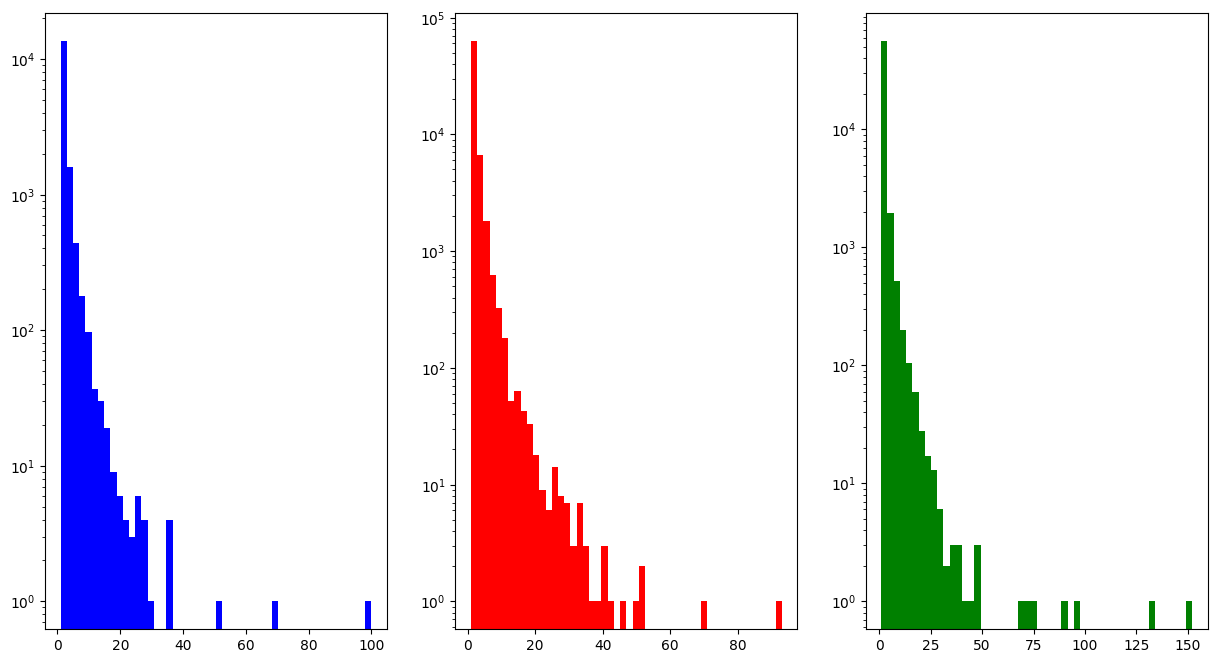

In [78]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.hist(e_e,bins=50, color='blue')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(i_i,bins=50, color='red')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(e_i,bins=50, color='green')
plt.yscale('log')

In [79]:
e_e = []
i_i = []
e_i = []

attr = 'duration'
for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append(attrs[attr])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append(attrs[attr]) 
    else: e_i.append(attrs[attr])

In [80]:
print(f'e_e mean = {np.mean(e_e)}')
print(f'e_i mean = {np.mean(e_i)}')
print(f'i_i mean = {np.mean(i_i)}')

e_e mean = 6316.320040193431
e_i mean = 5990.364396553189
i_i mean = 5777.0081550986615


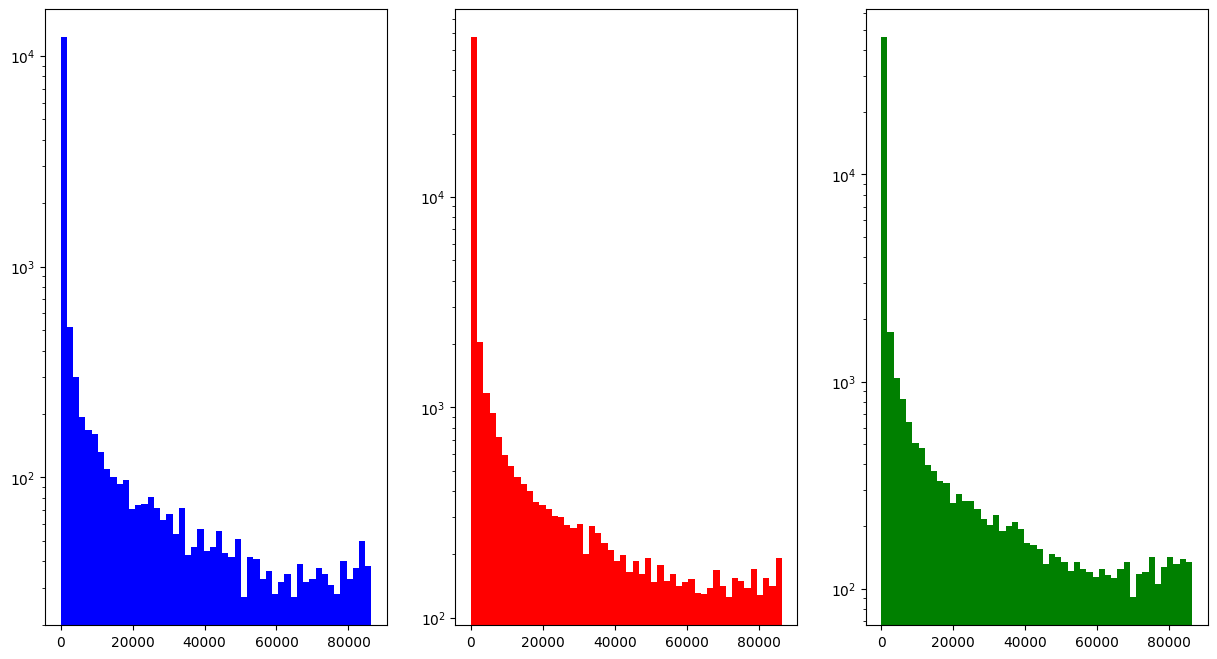

In [81]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.hist(e_e,bins=50, color='blue')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(i_i,bins=50, color='red')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(e_i,bins=50, color='green')
plt.yscale('log')

In [82]:
e_e = []
i_i = []
e_i = []

attr = 'overlap'
for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append(attrs[attr])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append(attrs[attr]) 
    else: e_i.append(attrs[attr])

In [83]:
print(f'e_e mean = {np.mean(e_e)}')
print(f'e_i mean = {np.mean(e_i)}')
print(f'i_i mean = {np.mean(i_i)}')

e_e mean = 0.02139449110472029
e_i mean = 0.02161510704304966
i_i mean = 0.020839523708189034


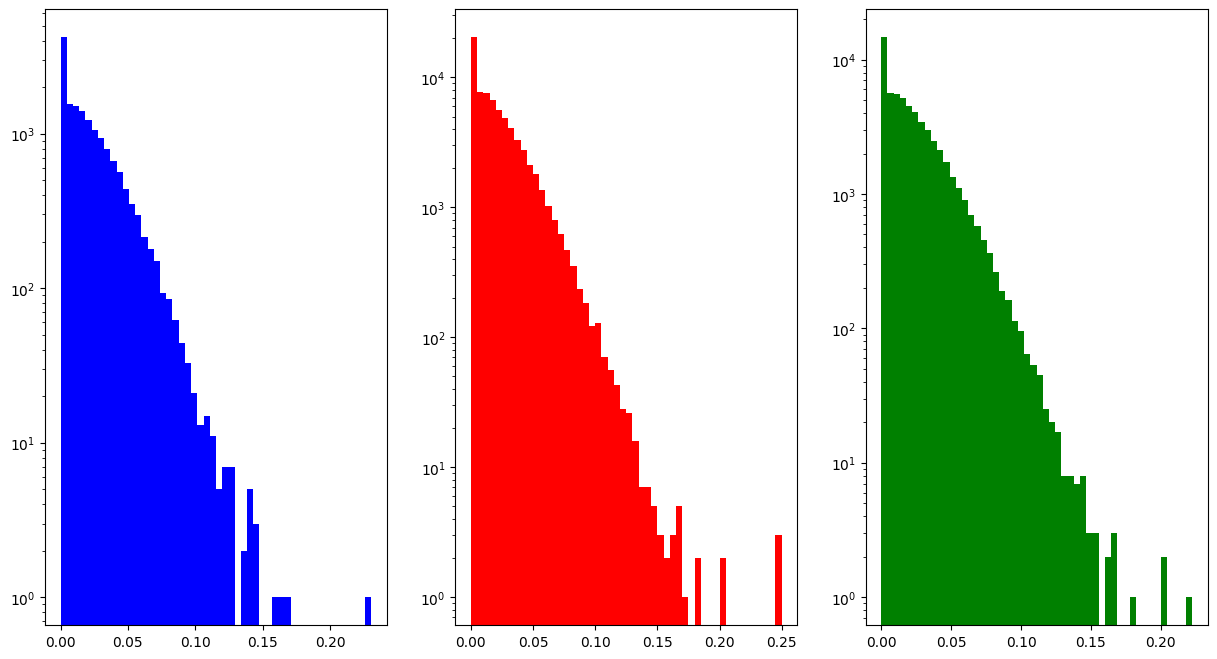

In [84]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.hist(e_e,bins=50, color='blue')
plt.yscale('log')
plt.subplot(1,3,2)
plt.hist(i_i,bins=50, color='red')
plt.yscale('log')
plt.subplot(1,3,3)
plt.hist(e_i,bins=50, color='green')
plt.yscale('log')

In [85]:
ranked_edges = G.edges(data=True)
e_e = []
i_i = []
e_i = []

for u,v,attrs in ranked_edges:
    if (author_to_class[u][0] == 'e' and author_to_class[v][0] == 'e'): e_e.append([attrs['weight'], attrs['overlap'], attrs['duration']])
    elif (author_to_class[u][0] == 'i' and author_to_class[v][0] == 'i'): i_i.append([attrs['weight'], attrs['overlap'], attrs['duration']]) 
    else: e_i.append([attrs['weight'], attrs['overlap'], attrs['duration']])

e_e = np.array(e_e)
e_i = np.array(e_i)
i_i = np.array(i_i)

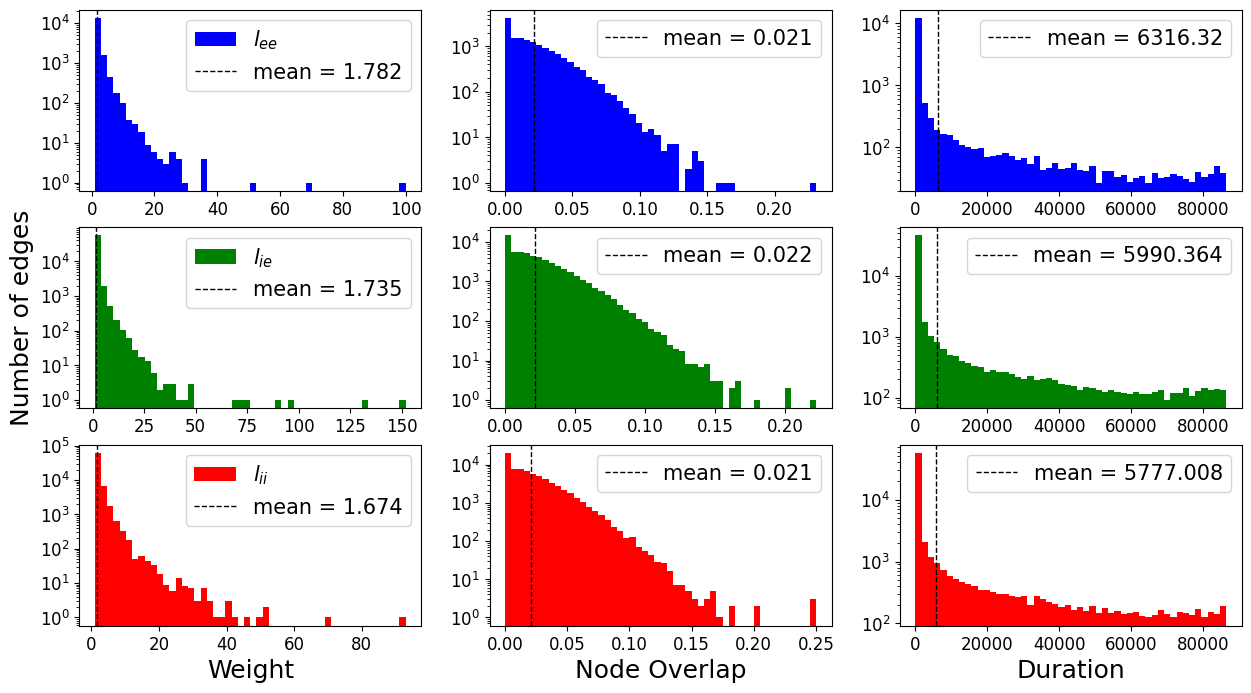

In [87]:
xlabel = ['Weight', 'Node Overlap', 'Duration']
title = ['Weight', 'Node Overlap', 'Duration']
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(3,3,i+1)
    #plt.title(title[i])
    if i == 0: plt.hist(e_e[:,i], bins=50, color='blue', label=r'$l_{ee}$')
    else: plt.hist(e_e[:,i], bins=50, color='blue')
    plt.axvline(x=np.mean(e_e[:,i]), color='k', linestyle='--', linewidth=1, label=f'mean = {round(np.mean(e_e[:,i]),3)}')
    #if i == 0: plt.ylabel('Number of edges', size=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale('log')
    plt.legend(loc='best', fontsize=15)

    plt.subplot(3,3,i+4)
    
    if i == 0: plt.hist(e_i[:,i], bins=50, color='green', label=r'$l_{ie}$')
    else: plt.hist(e_i[:,i], bins=50, color='green')
    plt.axvline(x=np.mean(e_i[:,i]), color='k', linestyle='--', linewidth=1, label=f'mean = {round(np.mean(e_i[:,i]),3)}')
    if i == 0: plt.ylabel('Number of edges', size=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale('log')
    plt.legend(loc='best', fontsize=15)

    plt.subplot(3,3,i+7)
    if i == 0: plt.hist(i_i[:,i], bins=50, color='red', label=r'$l_{ii}$')
    else: plt.hist(i_i[:,i], bins=50, color='red')
    plt.axvline(x=np.mean(i_i[:,i]), color='k', linestyle='--', linewidth=1, label=f'mean = {round(np.mean(i_i[:,i]),3)}')
    #plt.text(x=np.mean(i_i[:,i])+np.mean(i_i[:,i])/5,y=np.histogram(i_i[:,i])[0][0], s=f'mean = {np.mean(i_i[:,i])}')
    #if i == 0: plt.ylabel('Number of edges', size=15)
    plt.xlabel(xlabel[i], size=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=15)
    plt.yscale('log')

We can see that the distributions and their mean values are similiar for each type of interaction (e_e, e_i and i_i), in general.
As expected removing edges with low node overlap (local bridges) first destroy the network faster
As anticipated, the initial removal of edges characterized by low node overlap (i.e., local bridges) leads to a more rapid disintegration of the network structure.

In [89]:
data = []
for u, v, attrs in G.edges(data=True):
    data.append([attrs['weight'], attrs['overlap'], attrs['duration']])
    
df = pd.DataFrame(data, columns=['weight', 'overlap', 'duration'])

correlation_matrix = df.corr()

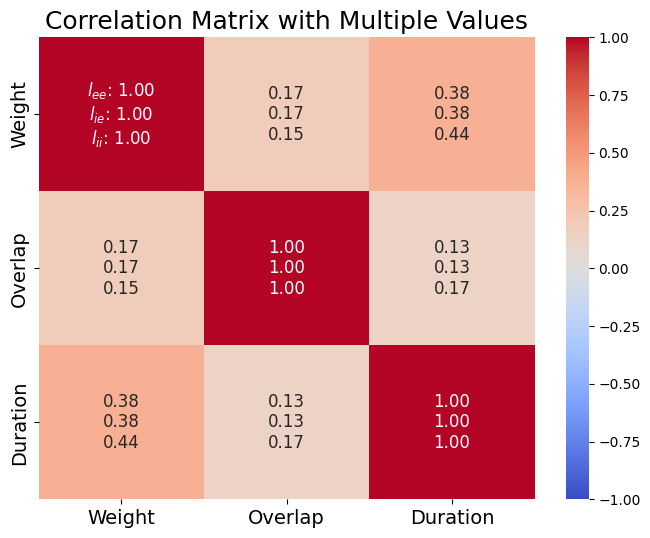

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example correlation matrix
df = pd.DataFrame(e_e, columns=['weight', 'overlap', 'duration'])

correlation_matrix = df.corr().to_numpy()

# Example additional values
df = pd.DataFrame(e_e, columns=['weight', 'overlap', 'duration'])

additional_values1 = df.corr().to_numpy()

df = pd.DataFrame(i_i, columns=['weight', 'overlap', 'duration'])

additional_values2 = df.corr().to_numpy()

l = [r'$l_{ee}$', r'$l_{ie}$', r'$l_{ii}$']

# Construct the custom annotations
annot = np.empty(correlation_matrix.shape, dtype=object)

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if (i == 0) and (j == 0): annot[i, j] = f"{l[0]}: {correlation_matrix[i, j]:.2f}\n{l[1]}: {additional_values1[i, j]:.2f}\n{l[2]}: {additional_values2[i, j]:.2f}"
        else: annot[i, j] = f"{correlation_matrix[i, j]:.2f}\n{additional_values1[i, j]:.2f}\n{additional_values2[i, j]:.2f}"

# Plot the heatmap with custom annotations
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=annot, fmt="", cmap='coolwarm', vmin=-1, vmax=1,
            annot_kws={"size": 12})  # Adjust the font size as needed
# Set custom x and y labels
x_labels = ['Weight', 'Overlap', 'Duration']
y_labels = ['Weight', 'Overlap', 'Duration']
heatmap.set_xticklabels(x_labels, size=14)  # Adjust font size as needed
heatmap.set_yticklabels(y_labels, size=14)  # Adjust font size as needed

plt.title('Correlation Matrix with Multiple Values', size=18)
plt.show()